# Orthogonal Decomposition Method with H∞ Controller and Observer Continuous Time

## Example: Flat Quadruped

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from numpy.linalg import pinv, norm,eig,inv
from scipy.integrate import odeint
from scipy.linalg import null_space, orth,inv

In [2]:
# Install MOSEK if not already installed
!pip install mosek

In [3]:
import cvxpy as cp

print(cp.installed_solvers())



['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


Function to check observability using Hautus lemma

In [4]:
def pbh_observability_test(A, C):
    lambdas, v = np.linalg.eig(A)
    n = np.shape(A)[0]
    ranks = n*[0]
    test = 'observable'
    for i in range(n):
      A_e = A - lambdas[i]*np.eye(n)
      M = np.vstack((A_e, C))
      ranks[i] = np.linalg.matrix_rank(M)
      if ranks[i] != n:
        test = 'not observable'
    return lambdas, ranks , test



---



Dynamics with Explicit Constraints: Model
\begin{equation}    
\begin{cases}
& \dot{x} = Ax+Bu+D_1w+F\lambda \\
& G \dot{x}= 0 \\
& y=Cx+D_2w
\end{cases}
\end{equation}


Linear model with implicit constraints:
\begin{equation}    
\begin{cases}
& \dot{z} = A_nz+A_r\zeta +B_n u+D_1w+F\lambda \\
& G \dot{x}= 0 \\
& y=Cx+D_2w
\end{cases}
\end{equation}
where $x=[z,\zeta]^T$

## Flat Quadruped Linearized Model with Constraints

In [5]:
## Load data form mat matrices

import scipy.io

J_mat = scipy.io.loadmat('J.mat')
J=J_mat['F']
print("J: ",J)

dJ_mat = scipy.io.loadmat('dJ.mat')
dJ=dJ_mat['dF']
print("dJ: ",dJ)


An_mat = scipy.io.loadmat('An.mat')
An=An_mat['An']
print("An: ",An)

Ar_mat = scipy.io.loadmat('Ar.mat')
Ar=Ar_mat['Ar']
print("Ar: ",Ar)

Bn_mat = scipy.io.loadmat('Bn.mat')
Bn=Bn_mat['Bn']
print("Bn: ",Bn)

J:  [[ 1.00000000e+00  0.00000000e+00 -5.19615243e-01 -5.19615243e-01
   0.00000000e+00 -2.59807621e-01  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00 -5.19615243e-01  0.00000000e+00
  -5.19615243e-01  0.00000000e+00 -2.59807621e-01]
 [ 0.00000000e+00  1.00000000e+00 -5.00000000e-01  7.70628283e-11
   0.00000000e+00  1.49999999e-01  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  7.70194741e-11  0.00000000e+00
   7.70194741e-11  0.00000000e+00  1.49999999e-01]]
dJ:  [[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
An:  [[ 1.98278390e+00 -1.43518817e+00 -8.06462857e-01  3.48727190e-01
   2.46671658e-01 -1.45198181e+00]
 [ 3.56623142e+00 -3.35265045e+00 -6.91532096e-01  5.10027628e-01
   1.63666590e+00 -1.25716575e+00]
 [-6.26268636e+00  7.70180539e+00  4.30891861e+00  6.07141500e-02
  -2.58297509e+00  1.22523464e+00]
 [-2.12971548e+00  6.26268069e+00  3.78070419e+00 -1.55585055e+00
   3.97123080e-01 -6.30329463e-01]
 [ 8.23007895e-03  5.42745042e-01 -1.1174536

Find  $G$ where:
$$
G=\begin{bmatrix}
J & 0\\
\frac{dJ}{dt} & J
\end{bmatrix}
$$

In [6]:
G=np.vstack((np.hstack((J,np.zeros((4,7)))),np.hstack((dJ,J))))
# print("G:",G)

Find Null space  $N$ and Row space  $R$ for $G$

In [7]:
N=null_space(G)
R=orth(G.T)



In [8]:
n=14
dof_z=6
dof_zeta=8

m=4 # dimentions of input
l=10 # dimentions of observer (it works starting from 8)

# C lxn (10,14)
C=np.array([[1,0,0,0,0,0,0,0,1,0,0,0,0,0],
            [0,1,0,0,0,0,0,0,0,1,0,0,0,0],
            [0,0,1,0,0,0,0,0,0,0,1,0,0,0],
            [0,0,0,1,0,0,0,0,0,0,0,1,0,0],
            [0,0,0,0,1,0,0,0,0,0,0,0,1,0],
            [0,0,0,0,0,1,0,0,0,0,0,0,0,1],
            [0,0,0,0,0,0,1,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,1,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,1,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,1,0,0,0,0]])

# print(C)

# D1  nxm (14,4)

D1=0.1*np.array([[1,0,0,0],
            [0,1,0,0],
            [0,0,1,0],
            [0,0,0,1],
            [1,0,0,0],
            [0,1,0,0],
            [0,0,1,0],
            [0,0,0,1],
            [1,0,0,0],
            [0,1,0,0],
            [0,0,1,0],
            [0,0,0,1],
            [0,0,0,0],
            [0,0,0,0]])
print(D1.shape)

# D2  lxm (10,4)

D2=0.01*np.array([[1,0,0,0],
            [0,1,0,0],
            [0,0,1,0],
            [0,0,0,1],
            [1,0,0,0],
            [0,1,0,0],
            [0,0,1,0],
            [0,0,0,1],
            [1,0,0,0],
            [0,1,0,0]])

# print(D2)



(14, 4)


Consider that the desired output is:
\begin{equation}
    z=C_1r+C_2e+D_3w
\end{equation}

In [9]:
### Desired output

## C1 dof_z x dof_z (6,6)
# C1=np.random.randn(dof_z, dof_z)
C1=0.1*np.eye(dof_z)
# print(C1)

## C2 dof_z x n (6,14)
C2=np.random.randn(dof_z, n)
C2=0.1*np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,1,0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,1,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,1,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,1,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,1,0,0,0,0,0,0,0,0]])

# print("C2: ",C2 )


## D3 dof_zxm (6,4)
D3=np.zeros((dof_z,m))



---



In [10]:
I=np.eye(n)

AE=np.vstack((np.hstack((An,Ar)),np.zeros((dof_zeta,n))))

B=Bn
D1c=D1

In [11]:
E=np.hstack((N,R))
# print("E: ",E)

In [12]:
S=np.vstack((np.eye(dof_z),np.zeros((dof_zeta,dof_z))))
N_bar=np.hstack((N,np.zeros((n,dof_zeta))))


In [13]:
A1=An#N.T@Ac@N
# B=N.T@Bc

Dn=N_bar.T@D1c
E=np.hstack((N,R))
A2=AE




Fixed state controller gain

In [14]:
K_q=-pinv(B,rcond=10**-9)@Ar

print("K_q: ",K_q)

K_q:  [[-3.49222459e-05 -2.25340697e+01 -2.49081143e-01 -1.01547960e-06
  -7.95071482e+00 -6.37187620e-05 -2.87955373e+01 -2.43809739e-05]
 [-3.81457301e-05 -3.61560366e+01 -8.06109924e-01 -1.64716998e-06
  -1.24497854e+01 -8.27805569e-05 -4.68937246e+01 -2.42621583e-05]
 [ 1.01227050e-05 -2.99833191e+01 -7.31156323e-01 -1.12797125e-06
  -1.13016678e+01 -1.95861821e-05 -3.91190701e+01  1.85230368e-05]
 [ 1.65696734e-05 -2.73938561e+00  3.82901236e-01  1.35409507e-07
  -2.30352670e+00  1.85374073e-05 -2.92269587e+00  1.82854056e-05]]


In [15]:
lambdas, ranks , test=pbh_observability_test(A2, C@E)

print(test)

observable




---



---



---



## Search for best epsilon to solve the LMI

In [17]:



gammas=[]
min_gamma=10000

epsilon_plot=[]



j=0
limit=10**-10
lower=limit
upper=1
kaps=np.linspace(0.000001, 1-0.000001,1000)
# for epsilon in epsilons:
for kap in  kaps:

  P1 = cp.Variable((dof_z,dof_z),symmetric=True)
  Q2 = cp.Variable((n,n),symmetric=True)

  U = cp.Variable((m,dof_z))
  # V = cp.Variable((14,14))
  # V = cp.Variable((14,8))
  V = cp.Variable((n,l))

  epsilon=kap/(1-kap)

  gamma=cp.Variable()

  obj = cp.Minimize(gamma)
  constraints = []

  Psi1=P1@A1.T+A1@P1+B@U+U.T@B.T
  Psi2=A2.T@Q2+Q2@A2-V@C@E-E.T@C.T@V.T



  H=cp.vstack((cp.hstack((P1,np.zeros((dof_z,dof_zeta)))),cp.hstack((np.zeros((dof_zeta,dof_z)),np.eye(dof_zeta)))))


  Term1=cp.hstack((B@U,B@K_q))




  LMI= cp.bmat([[Psi1,np.zeros((dof_z,n)),S.T@Dn,P1@C1.T,Term1,np.zeros((dof_z,n))],
    [np.zeros((n,dof_z)),Psi2,Q2@Dn-V@D2,C2.T,np.zeros((n,n)),np.eye(n)],
    [Dn.T@S,Dn.T@Q2-D2.T@V.T,-gamma*np.eye(m),D3.T,np.zeros((m,n)),np.zeros((m,n))],
    [C1@P1,C2,D3,-gamma*np.eye(dof_z),np.zeros((dof_z,n)),np.zeros((dof_z,n))],
    [Term1.T,np.zeros((n,n)),np.zeros((n,m)),np.zeros((n,dof_z)),-(1/epsilon)*H,np.zeros((n,n))],
    [np.zeros((n,dof_z)),np.eye(n),np.zeros((n,m)),np.zeros((n,dof_z)),np.zeros((n,n)),-epsilon*H]])

  constraints.extend([P1>>0])
  constraints.extend([Q2>>0])
  constraints.extend([LMI<<0])
  constraints.extend([gamma>=0])




  prob = cp.Problem(obj, constraints)

  # result = prob.solve(solver=cp.MOSEK,verbose=True)
  # result = prob.solve(solver=cp.MOSEK)
  try:
        result = prob.solve(solver=cp.MOSEK)
        # break
  except:
        print("Oops!  That was no valid number.  Try again...")
        # break;

      # print(j)
  if gamma.value!=None:
    print("gamma: ", gamma.value)
    print("epsilon: ", epsilon)
    if min_gamma>=gamma.value:
      min_gamma=gamma.value
      target_epsilon=epsilon
    gammas.append(gamma.value)
    epsilon_plot.append(epsilon)
    # e_p, _ = np.linalg.eig(P1.value)
    # e_q, _ = np.linalg.eig(Q2.value)


    # print("eig of P1: ",e_p)
    # print("eig of Q2: ",e_q)

    K_r=U.value@pinv(P1.value,rcond=10**-9)
    L=pinv(Q2.value,rcond=10**-9)@V.value

    print("K_r: ",K_r)
    print("L: ",L)
  if epsilon>1:
    break;


gamma:  3185.6888010003486
epsilon:  1.000001000001e-06
K_r:  [[  440158.51438113   114049.00938006   549906.95124208  -827249.7848938
    -73442.73355016  -594137.20683119]
 [ -233109.02426256  -420677.10077732 -1178975.7301567     77131.13621546
   -428116.46813715   463220.38141641]
 [  299654.16172825   -64596.98996529   110331.76973088  -679656.52557636
   -270364.26933356  -366765.43771344]
 [ -146699.00207152  -111787.12458266  -409162.85443692   255646.52715112
    -74985.17830044   216664.97758466]]
L:  [[-2.28761794e+00  4.57830019e+00 -1.61658706e+01 -1.44147079e+00
  -1.03479259e+01 -1.92511697e+01  9.67012078e-01  5.19314284e+00
   1.03625917e+01  1.20056880e+01]
 [-3.43002732e+00  2.01086055e+00  3.71262774e-01  8.23806655e-01
  -7.08944613e+00 -3.08274250e+00 -2.65147042e+00  7.99378982e+00
   1.40129097e+01  2.79329660e+00]
 [ 3.19156441e+01 -1.01256122e+01  5.10497698e+01  7.68773653e+00
   2.94185064e+01  4.08830949e+01 -1.98825903e+01 -4.53135741e+00
  -5.12767597e+0

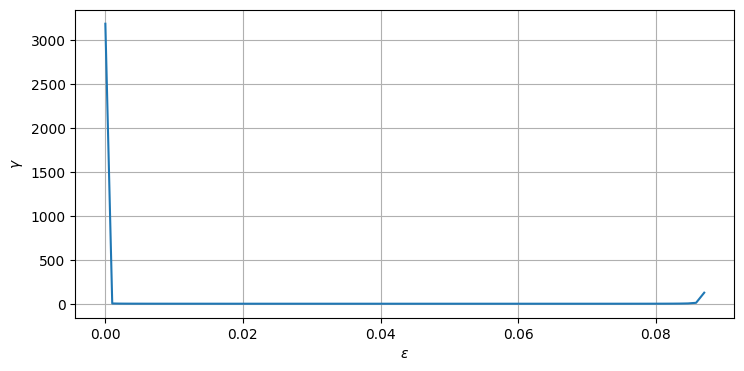

min_gamma:  0.06245988188989365
target_epsilon:  0.06845019317659706


In [20]:
from matplotlib.pyplot import *

figure(figsize=(8.5, 4.))
plot(epsilon_plot,gammas)
xlabel(r'$\epsilon$')
ylabel(r'$\gamma$')
grid()
show()

print("min_gamma: ",min_gamma)
print("target_epsilon: ",target_epsilon)





---



## Best epsilon controller

In [21]:
# Import time module
import time

# record start time
start = time.time()

n=14
m=4

I=np.eye(n)

epsilon=target_epsilon



P1 = cp.Variable((dof_z,dof_z),symmetric=True)
Q2 = cp.Variable((n,n),symmetric=True)

U = cp.Variable((m,dof_z))
V = cp.Variable((n,l))



gamma=cp.Variable()

obj = cp.Minimize(gamma)
constraints = []

Psi1=P1@A1.T+A1@P1+B@U+U.T@B.T
Psi2=A2.T@Q2+Q2@A2-V@C@E-E.T@C.T@V.T



H=cp.vstack((cp.hstack((P1,np.zeros((dof_z,dof_zeta)))),cp.hstack((np.zeros((dof_zeta,dof_z)),np.eye(dof_zeta)))))


Term1=cp.hstack((B@U,B@K_q))


LMI= cp.bmat([[Psi1,np.zeros((dof_z,n)),S.T@Dn,P1@C1.T,Term1,np.zeros((dof_z,n))],
[np.zeros((n,dof_z)),Psi2,Q2@Dn-V@D2,C2.T,np.zeros((n,n)),np.eye(n)],
[Dn.T@S,Dn.T@Q2-D2.T@V.T,-gamma*np.eye(m),D3.T,np.zeros((m,n)),np.zeros((m,n))],
[C1@P1,C2,D3,-gamma*np.eye(dof_z),np.zeros((dof_z,n)),np.zeros((dof_z,n))],
[Term1.T,np.zeros((n,n)),np.zeros((n,m)),np.zeros((n,dof_z)),-(1/epsilon)*H,np.zeros((n,n))],
[np.zeros((n,dof_z)),np.eye(n),np.zeros((n,m)),np.zeros((n,dof_z)),np.zeros((n,n)),-epsilon*H]])



constraints.extend([P1>>0])
constraints.extend([Q2>>0])
constraints.extend([LMI<<0])
constraints.extend([gamma>=0])


prob = cp.Problem(obj, constraints)

result = prob.solve(solver=cp.MOSEK,verbose=True)


# record end time
end = time.time()

# print the difference between start
# and end time in milli. secs
print()

print("The time of execution of above program is :",
      (end-start) * 10**3, "ms")
print()
print("gamma: ", gamma.value)


e_p, _ = np.linalg.eig(P1.value)
e_q, _ = np.linalg.eig(Q2.value)


print("eig of P1: ",e_p)
print("eig of Q2: ",e_q)


K_r=U.value@pinv(P1.value)
L=pinv(Q2.value)@V.value

print("K_r: ",K_r)
print("L: ",L)



                                     CVXPY                                     
                                     v1.3.3                                    
(CVXPY) Feb 06 05:27:32 PM: Your problem has 397 variables, 4 constraints, and 0 parameters.
(CVXPY) Feb 06 05:27:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 06 05:27:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 06 05:27:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 06 05:27:32 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Feb 06 05:27:32 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

In [22]:
## Check closed loop stability
K=np.hstack((K_r,K_q))
A_close=np.vstack((np.hstack((A1+B@K_r,-B@K)),np.hstack((np.zeros((14,6)),A2-L@C@E))))

e, _ = np.linalg.eig(A_close)
print("eigenvalues of the closed loop system: ",e)

print("max eigenvalue: ",max(e.real))

eigenvalues of the closed loop system:  [-11.22015475 +0.j         -10.31522031 +0.j
  -6.28656534 +0.j          -2.05307097 +0.j
  -0.98527169 +0.j          -1.59401647 +0.j
  -1.37355449+14.16163293j  -1.37355449-14.16163293j
  -1.53428325+10.27747335j  -1.53428325-10.27747335j
  -1.2782637  +6.26114788j  -1.2782637  -6.26114788j
  -4.18662218 +0.j          -1.27085238 +3.4750173j
  -1.27085238 -3.4750173j   -1.52615328 +1.63388804j
  -1.52615328 -1.63388804j  -1.2132527  +0.j
  -0.46946966 +0.j          -0.12688963 +0.j        ]
max eigenvalue:  -0.1268896266960565


## Simulation

In [23]:
import numpy as np
from scipy.integrate import odeint
from scipy.signal import place_poles
from matplotlib.pyplot import *
from scipy.integrate import odeint



def sys_ode(state, t):

    w=1*np.array([np.sin(t),np.sin(t),np.sin(t),np.sin(t)])
    # w=np.array([1,1,1,1])
    #w=np.array([0,0,0,0])

    x= state[0:n]
    r=x[0:dof_z]
    q=x[dof_z:]
    x_hat=state[n:]


    #A_o=np.vstack((np.hstack((N.T@Ac@N,N.T@Ac@R)),np.zeros((4,6))))
    A_o=np.vstack((np.hstack((An,Ar)),np.zeros((dof_zeta,n))))

    B_o=np.vstack((B,np.zeros((dof_zeta,m))))

    u=K@x_hat

    y_hat=C@E@x_hat

    y=C@E@x+D2@w


    dx_hat=A_o@x_hat+B_o@u+L@(y-y_hat)


    e=x-x_hat

    dr=An@r+B@K_r@r-B@K@e+N.T@D1c@w

    dx = np.hstack((dr, [0,0,0,0,0,0,0,0]))

    dstate = np.hstack((dx, dx_hat))
    return dstate


In [24]:
T = 30 # Final time

t = np.linspace(0, T, int(2E3)) # Create time span

x_real_0 = [1,0,0,0,0,0,0,0,0,0,0,0,1,0] # Set initial state
x_hat_0 =  [1.1,0.1,0,0,0,0,0,0,0,0,0,0,1.2,0.01]


state_0 = np.hstack((x_real_0, x_hat_0))

state_sol = odeint(sys_ode, state_0, t)

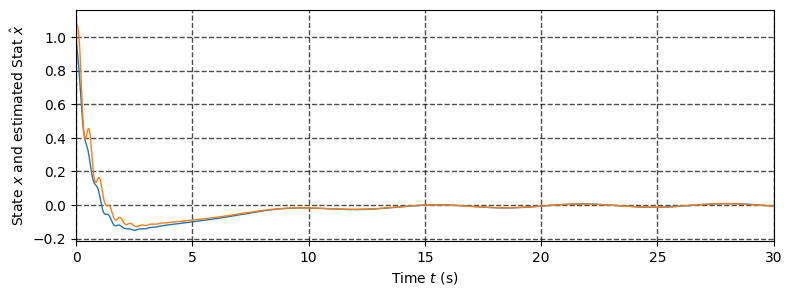

In [25]:
figure(figsize=(9, 3))

plot(t, state_sol[:,0], linewidth=1.0)
plot(t, state_sol[:,14], linewidth=1.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([0, T])
ylabel(r'State ${x}$ and estimated Stat $\hat{x}$')
xlabel(r'Time $t$ (s)')
show()


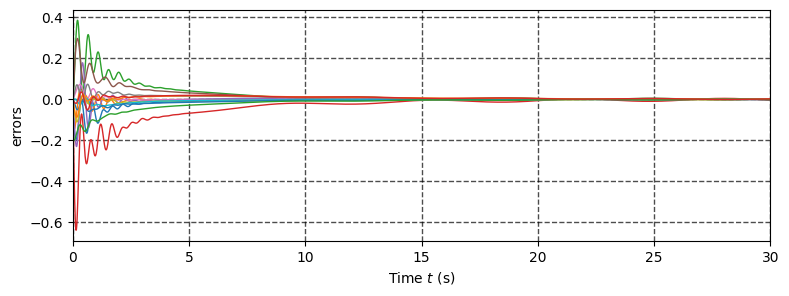

In [26]:
error=state_sol[:,:14]-state_sol[:,14:]


figure(figsize=(9, 3))
plot(t,error, linewidth=1.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([0, T])
ylabel(r'errors')
xlabel(r'Time $t$ (s)')
show()


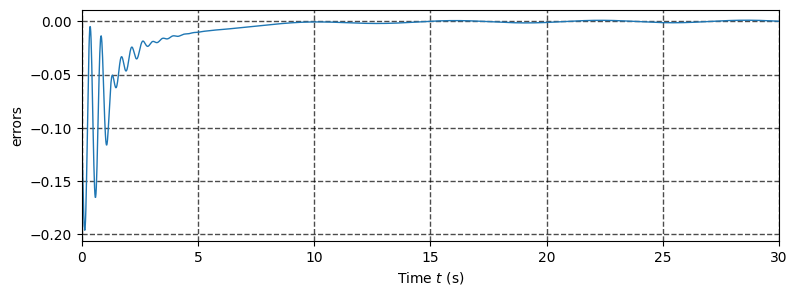

In [27]:
figure(figsize=(9, 3))
plot(t,error[:,0], linewidth=1.0)
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([0, T])
ylabel(r'errors')
xlabel(r'Time $t$ (s)')
show()


Output

In [28]:
z=[]

for i in range(len(state_sol)):

  dt=T/int(2E3)
  w=np.array([np.sin(i*dt),np.sin(i*dt),np.sin(i*dt),np.sin(i*dt)])
  res=C1@state_sol[i,0:6]+C2@error[i]+D3@w
  # print(res)
  z.append(res)
z=np.array(z)

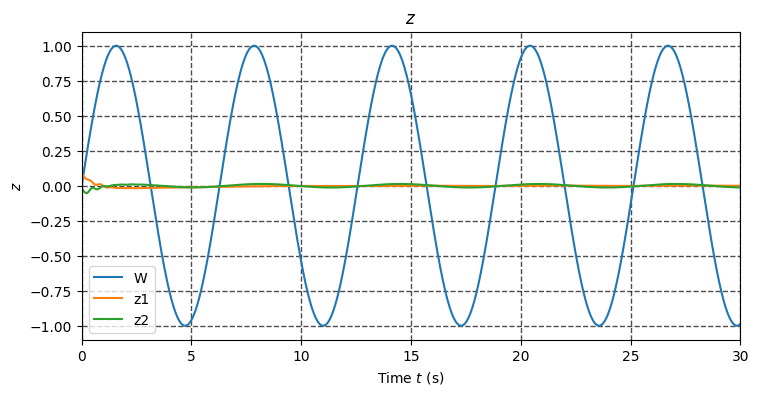

In [29]:
# plot theta1 and theta2
from matplotlib.pyplot import *

z1, z2 ,z3 , z4 ,z5 ,z6= z[:,0], z[:,1], z[:,2], z[:,3], z[:,4], z[:,5]

figure(figsize=(8.5, 4.))
title(r'$z$')
plot(t,np.sin(t),label='W')
plot(t,z1,label='z1')
plot(t,z2,label='z2')
# plot(t,z3,label='z3')
# plot(t,z4,label='z4')
# plot(t,z5,label='z5')
# plot(t,z6,label='z6')

legend()
xlim([0, T])
# ylim([-0.5, 0.5])

grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
ylabel(r'$z$')
xlabel(r'Time $t$ (s)')

show()

